# Inhibitor effect on celltype

In [5]:
# If problems installing slingshot
# sudo apt-get update
# sudo apt-get install libglu1-mesa-dev 
# sudo apt-get install freeglut3-dev
# sudo apt-get install mesa-common-dev
# then
# install.packages("rgl")
# BiocManager::install("slingshot")
library(dplyr)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(ggplot2)
library(pheatmap)
library(cowplot)
library(reshape2)

In [6]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/R4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] reshape2_1.4.4     cowplot_1.0.0      pheatmap_1.0.12    ggplot2_3.3.1     
[5] destiny_3.2.0      RColorBrewer_1.1-2 dplyr_1.0.0       

loaded via a namespace (and not attached):
 [1] bitops_1.0-6                matrixStats_0.56.0         
 [3] xts_0.12-0                  GenomeInfoDb_1.24.0        

# Process with Seurat from raw

In [7]:
metadata = read.csv('data/scATAC/seurat.output-S2/data/barcode_metadata.csv', stringsAsFactors = F)
names(metadata)[1] = 'index'
names(metadata)[ names(metadata) == 'inhibitor' ] = 'Inhibition'
names(metadata)[ names(metadata) == 'day' ] = 'Days'
names(metadata)[ names(metadata) == 'seurat_clusters' ] = 'clusters'

In [8]:
create_contingency_table = function(perturbed_cl, control_cl, perturbed, control){
    if(length(perturbed_cl) == 0 || length(control_cl) == 0){
        perturbed_cl = c(perturbed_cl, '1')
        control_cl = c(control_cl, '1')
        perturbed = c(perturbed, '1')
        control = c(control, '1')
    }
    m = matrix(c(length(perturbed_cl), length(control_cl), 
               length(perturbed),  length(control)), 
             ncol = 2, dimnames = list(c('I', 'C'), c('in_cl', 'total')) )
  return(m)  
}


enrichment = function(perturbed_cl, control_cl, perturbed, control){
  funtable = create_contingency_table(perturbed_cl, control_cl, perturbed, control)
  out = NULL
#   if ( funtable[1,1] > 1 ){
    ft = fisher.test(funtable)
    pvalue = ft$p.value
    estimate = ft$estimate
    conf.int = ft$conf.int
    out = data.frame(pvalue= pvalue, odds.ratio = estimate, min_confint = conf.int[1], max_confint = conf.int[2],  stringsAsFactors = F)
  return(out)
#   }
}

test_cluster = function(cl){
    message(cl)
    results = list()
    for (I in inhibitors)
        for (tm in times){
            perturbed = subset(metadata, Inhibition == I & Days == tm)$index
            perturbed_cl = subset(metadata, Inhibition == I & Days == tm & clusters == cl)$index
            control = subset(metadata, Inhibition == 'N_I' & Days == tm)$index
            control_cl = subset(metadata, Inhibition == 'N_I' & Days == tm & clusters == cl)$index
            out = enrichment(perturbed_cl, control_cl, perturbed, control)
            if( is.null(out))
                next()
            out$inhibitor2 = I
            out$inhibitor = I
            out$id = paste0(out$inhibitor , ' day', tm)
            out$cell_type = cl
            results[[paste0(I, '_day', tm) ]] = out

        }
    df = melt(results, id.vars = colnames(results[[1]]))[, -9]
    df$pvalue_adj = p.adjust(df$pvalue, method = 'bonferroni')
    df$label = ifelse(df$pvalue_adj < 0.05, '*', '')
    df$label[ df$pvalue_adj < 0.01] = '**'
    df$label[ df$pvalue_adj < 0.001] = '***'
    print(df)
    
    y_max = max(df$max_confint[ ! is.infinite(df$max_confint) ] )
    y_max = log(y_max) + 0.7
    P = ggplot(df, aes(x=id, y=log(odds.ratio), fill = inhibitor, label = label) ) + 
       # scale_y_continuous(limits = log(c(min(df$min_confint[ ! is.infinite(df$min_confint) ]), max(df$max_confint[ ! is.infinite(df$max_confint) ] ) )) ) + 
        scale_y_continuous(limits = c(log(min(df$min_confint[ ! is.infinite(df$min_confint) ])), y_max) ) + 
        geom_bar(stat = 'identity') + 
        geom_point(show.legend = F) + 
        geom_errorbar(mapping = aes(ymin = log(min_confint), ymax = log(max_confint)), width=0.5, size=0.2) +
        geom_text(color = 'black', y = y_max*0.9, size = 8) +
        scale_fill_manual(values = c("#6c94d9", "#e39696") ) +
        theme_bw(18) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1), 
                             panel.grid.major = element_blank(), panel.grid.minor = element_blank()) + 
        ggtitle(cl) + xlab('') + ylab('odds ratio (log scale)\n N cells enrichment')
    P
    
    ggsave(filename = paste0('data/scATAC/seurat.output-S2/general/barplot_inhibitorsenrichment_', cl, '.pdf') )
    return(P)
}

9



        pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1 2.696010e-05  0.4842911   0.3388256   0.6892345   NOTCH-in  NOTCH-in
2 7.301262e-18  3.2489800   2.4588265   4.3096889   NOTCH-in  NOTCH-in
3 5.984926e-01  1.0884136   0.8011225   1.4832110     WNT-in    WNT-in
4 1.422400e-01  0.7646274   0.5284732   1.0954758     WNT-in    WNT-in
             id cell_type   pvalue_adj label
1 NOTCH-in day3         9 1.078404e-04   ***
2 NOTCH-in day7         9 2.920505e-17   ***
3   WNT-in day3         9 1.000000e+00      
4   WNT-in day7         9 5.689598e-01      


Saving 6.67 x 6.67 in image

5



         pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1  1.451075e-03   1.503855   1.1642334    1.951743   NOTCH-in  NOTCH-in
2 5.452572e-108  22.802114  15.3994877   35.028088   NOTCH-in  NOTCH-in
3  1.616544e-05   1.729659   1.3347610    2.251705     WNT-in    WNT-in
4  4.075888e-01   1.277930   0.7184863    2.265633     WNT-in    WNT-in
             id cell_type    pvalue_adj label
1 NOTCH-in day3         5  5.804299e-03    **
2 NOTCH-in day7         5 2.181029e-107   ***
3   WNT-in day3         5  6.466176e-05   ***
4   WNT-in day7         5  1.000000e+00      


Saving 6.67 x 6.67 in image

7



        pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1 1.023877e-01  0.7527423   0.5328926   1.0650453   NOTCH-in  NOTCH-in
2 2.232226e-21  0.3122812   0.2341738   0.4105030   NOTCH-in  NOTCH-in
3 2.801849e-02  0.6612829   0.4539922   0.9604323     WNT-in    WNT-in
4 6.870743e-12  0.5350834   0.4421646   0.6451741     WNT-in    WNT-in
             id cell_type   pvalue_adj label
1 NOTCH-in day3         7 4.095508e-01      
2 NOTCH-in day7         7 8.928904e-21   ***
3   WNT-in day3         7 1.120739e-01      
4   WNT-in day7         7 2.748297e-11   ***


Saving 6.67 x 6.67 in image

10



        pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1 4.543868e-01  1.1266850   0.8299693   1.5373975   NOTCH-in  NOTCH-in
2 8.722198e-09 10.7454114   4.0348269  36.0150628   NOTCH-in  NOTCH-in
3 1.688260e-02  0.6511151   0.4526765   0.9338238     WNT-in    WNT-in
4 5.013726e-03  4.1281832   1.4245531  14.5331681     WNT-in    WNT-in
             id cell_type   pvalue_adj label
1 NOTCH-in day3        10 1.000000e+00      
2 NOTCH-in day7        10 3.488879e-08   ***
3   WNT-in day3        10 6.753039e-02      
4   WNT-in day7        10 2.005491e-02     *


Saving 6.67 x 6.67 in image

6



        pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1 1.332375e-02  1.8039738   1.1223473   2.9803036   NOTCH-in  NOTCH-in
2 9.757727e-36  0.2087079   0.1516903   0.2815066   NOTCH-in  NOTCH-in
3 5.798083e-01  0.8544335   0.4776269   1.5333851     WNT-in    WNT-in
4 7.171105e-01  0.9729385   0.8413024   1.1243197     WNT-in    WNT-in
             id cell_type   pvalue_adj label
1 NOTCH-in day3         6 5.329500e-02      
2 NOTCH-in day7         6 3.903091e-35   ***
3   WNT-in day3         6 1.000000e+00      
4   WNT-in day7         6 1.000000e+00      


Saving 6.67 x 6.67 in image

0



         pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1  1.925701e-04  0.3967166  0.23409200  0.66095561   NOTCH-in  NOTCH-in
2  4.149149e-88  0.2272821  0.19061871  0.26957124   NOTCH-in  NOTCH-in
3  9.172675e-01  0.9696167  0.63265983  1.49252956     WNT-in    WNT-in
4 7.182735e-276  0.0269378  0.01805428  0.03871386     WNT-in    WNT-in
             id cell_type    pvalue_adj label
1 NOTCH-in day3         0  7.702802e-04   ***
2 NOTCH-in day7         0  1.659660e-87   ***
3   WNT-in day3         0  1.000000e+00      
4   WNT-in day7         0 2.873094e-275   ***


Saving 6.67 x 6.67 in image



Error in Re[[cl]] <- test_cluster(cl) : 
  attempt to select less than one element in integerOneIndex


3



        pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1 6.463599e-02   1.366219   0.9764276    1.928447   NOTCH-in  NOTCH-in
2 2.373777e-05   1.419784   1.2043627    1.671740   NOTCH-in  NOTCH-in
3 5.101989e-01   0.874070   0.5952510    1.285547     WNT-in    WNT-in
4 7.295242e-06   1.389478   1.2017369    1.606644     WNT-in    WNT-in
             id cell_type   pvalue_adj label
1 NOTCH-in day3         3 2.585439e-01      
2 NOTCH-in day7         3 9.495107e-05   ***
3   WNT-in day3         3 1.000000e+00      
4   WNT-in day7         3 2.918097e-05   ***


Saving 6.67 x 6.67 in image

11



        pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1 1.316781e-03  0.3162702   0.1381674   0.6808813   NOTCH-in  NOTCH-in
2 2.819391e-89 20.5878198  13.6739403  32.2239626   NOTCH-in  NOTCH-in
3 1.510685e-02  0.4141458   0.1862824   0.8750456     WNT-in    WNT-in
4 5.862930e-02  0.4764488   0.1961566   1.0508341     WNT-in    WNT-in
             id cell_type   pvalue_adj label
1 NOTCH-in day3        11 5.267122e-03    **
2 NOTCH-in day7        11 1.127757e-88   ***
3   WNT-in day3        11 6.042741e-02      
4   WNT-in day7        11 2.345172e-01      


Saving 6.67 x 6.67 in image

2



         pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1  8.604418e-02 0.16537298 0.003356366  1.67608402   NOTCH-in  NOTCH-in
2  4.762593e-39 0.40732223 0.351163252  0.47111492   NOTCH-in  NOTCH-in
3  1.775291e-01 0.19850078 0.004027319  2.01253751     WNT-in    WNT-in
4 1.500809e-253 0.01772833 0.010269944  0.02856464     WNT-in    WNT-in
             id cell_type    pvalue_adj label
1 NOTCH-in day3         2  3.441767e-01      
2 NOTCH-in day7         2  1.905037e-38   ***
3   WNT-in day3         2  7.101166e-01      
4   WNT-in day7         2 6.003238e-253   ***


Saving 6.67 x 6.67 in image

1



         pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1  4.547343e-03  2.1207306   1.2357755   3.7967779   NOTCH-in  NOTCH-in
2  1.956637e-08  0.4455525   0.3225861   0.6054806   NOTCH-in  NOTCH-in
3  8.792372e-01  1.0855590   0.5721718   2.0952657     WNT-in    WNT-in
4 4.783624e-266  8.3163954   7.2183092   9.6096740     WNT-in    WNT-in
             id cell_type    pvalue_adj label
1 NOTCH-in day3         1  1.818937e-02     *
2 NOTCH-in day7         1  7.826550e-08   ***
3   WNT-in day3         1  1.000000e+00      
4   WNT-in day7         1 1.913450e-265   ***


Saving 6.67 x 6.67 in image

8



         pvalue  odds.ratio  min_confint max_confint inhibitor2 inhibitor
1  9.034944e-13  0.01950270 0.0004829430   0.1167091   NOTCH-in  NOTCH-in
2 1.011002e-178 12.11136922 9.8266722208  15.0389133   NOTCH-in  NOTCH-in
3  2.941329e-11  0.02340280 0.0005783857   0.1401186     WNT-in    WNT-in
4  1.381598e-20  0.06145036 0.0195473007   0.1479511     WNT-in    WNT-in
             id cell_type    pvalue_adj label
1 NOTCH-in day3         8  3.613978e-12   ***
2 NOTCH-in day7         8 4.044008e-178   ***
3   WNT-in day3         8  1.176532e-10   ***
4   WNT-in day7         8  5.526392e-20   ***


Saving 6.67 x 6.67 in image

4



         pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1  2.827563e-01   1.172071   0.8739339    1.579675   NOTCH-in  NOTCH-in
2  6.537961e-01   1.086293   0.7513880    1.553112   NOTCH-in  NOTCH-in
3  3.720425e-02   1.369160   1.0179329    1.850243     WNT-in    WNT-in
4 1.229712e-188  12.028204   9.6930140   15.069236     WNT-in    WNT-in
             id cell_type    pvalue_adj label
1 NOTCH-in day3         4  1.000000e+00      
2 NOTCH-in day7         4  1.000000e+00      
3   WNT-in day3         4  1.488170e-01      
4   WNT-in day7         4 4.918846e-188   ***


Saving 6.67 x 6.67 in image

12



        pvalue odds.ratio min_confint max_confint inhibitor2 inhibitor
1 1.000000e+00  1.0384184   0.3653708    3.176766   NOTCH-in  NOTCH-in
2 1.000000e+00  1.0752101   0.2366855    4.018664   NOTCH-in  NOTCH-in
3 3.885043e-01  0.5668858   0.1411787    2.085888     WNT-in    WNT-in
4 4.038146e-09  7.0511704   3.2585968   17.432052     WNT-in    WNT-in
             id cell_type   pvalue_adj label
1 NOTCH-in day3        12 1.000000e+00      
2 NOTCH-in day7        12 1.000000e+00      
3   WNT-in day3        12 1.000000e+00      
4   WNT-in day7        12 1.615259e-08   ***


Saving 6.67 x 6.67 in image



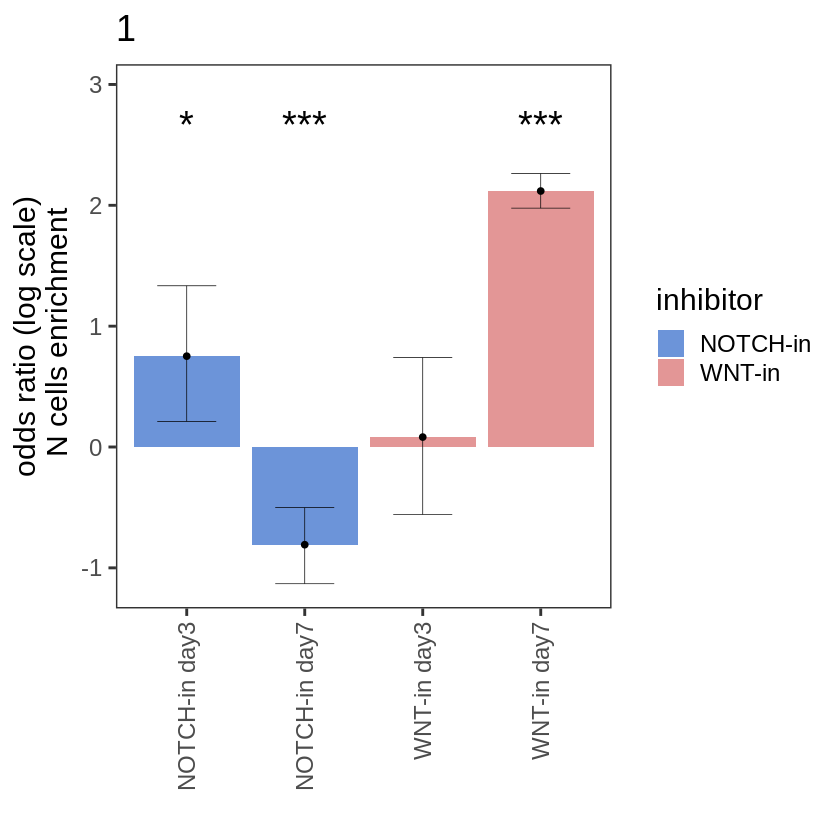

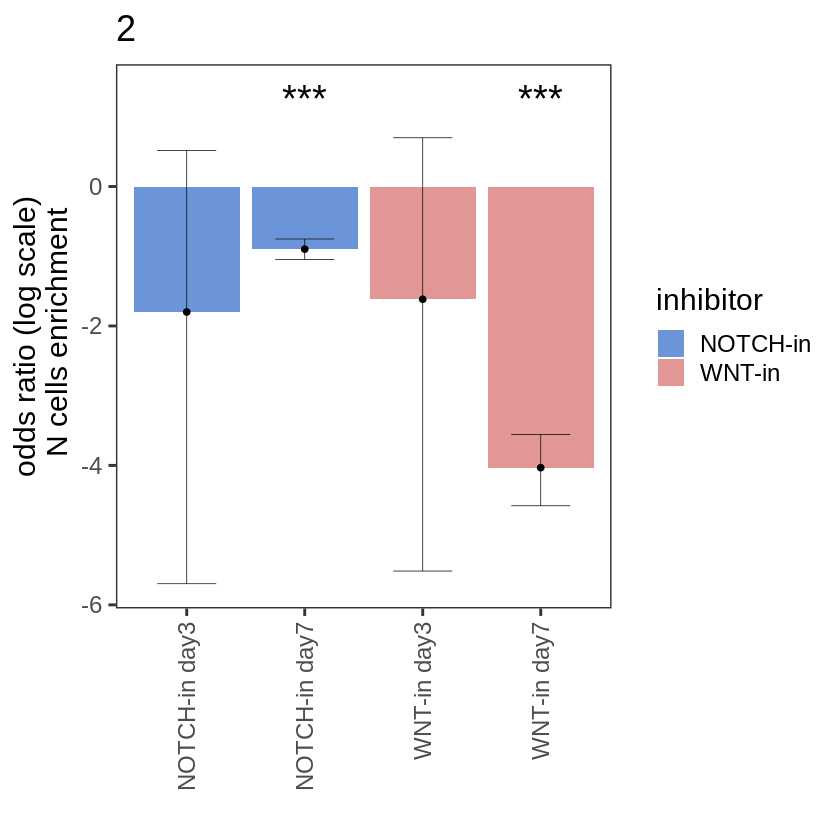

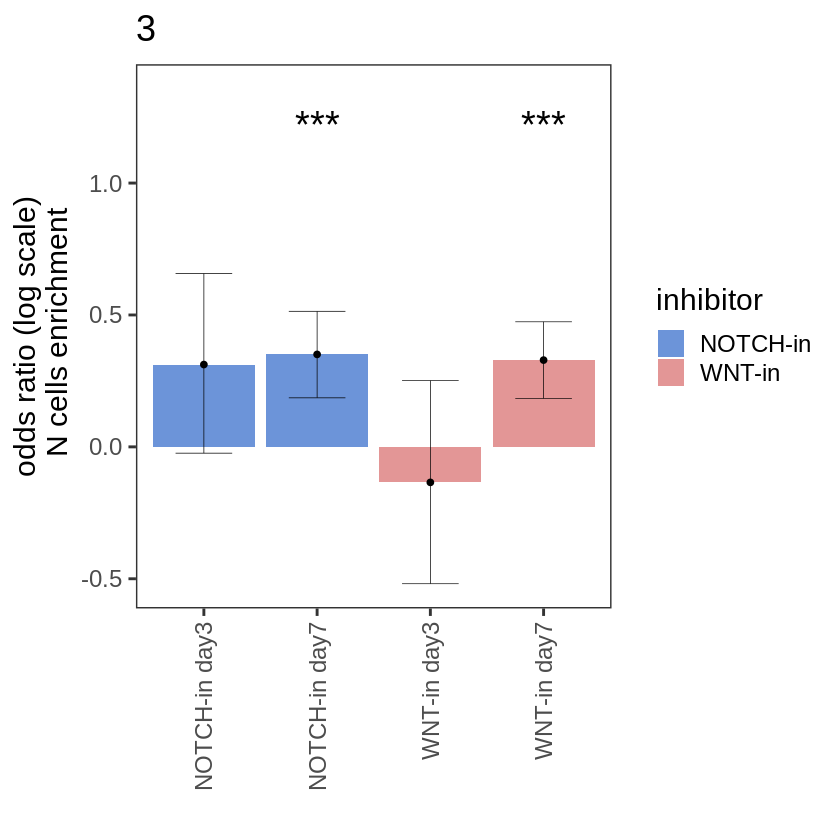

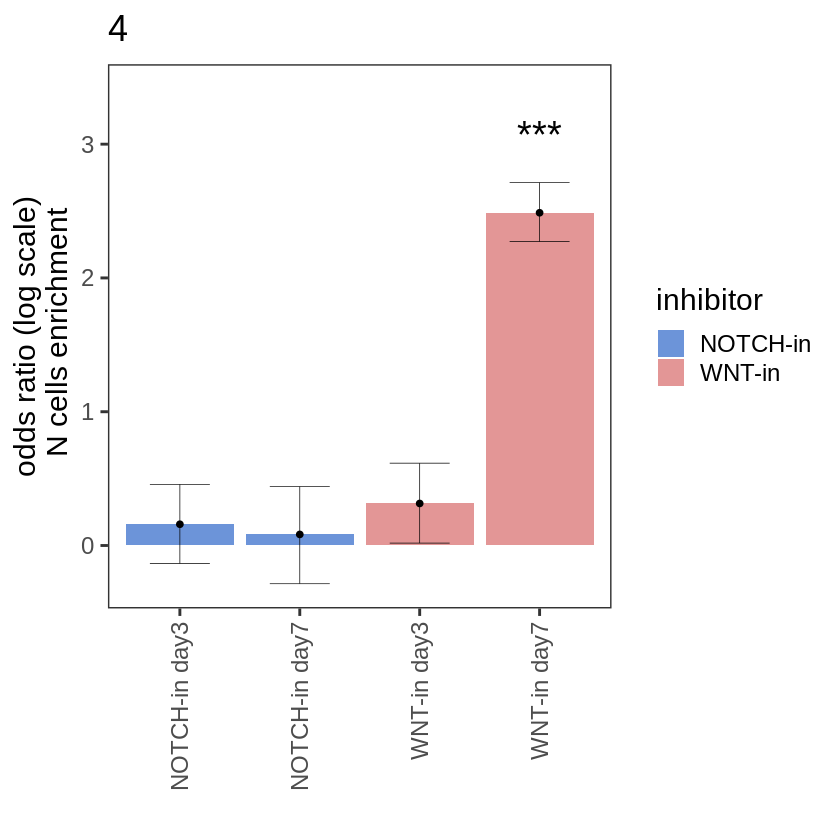

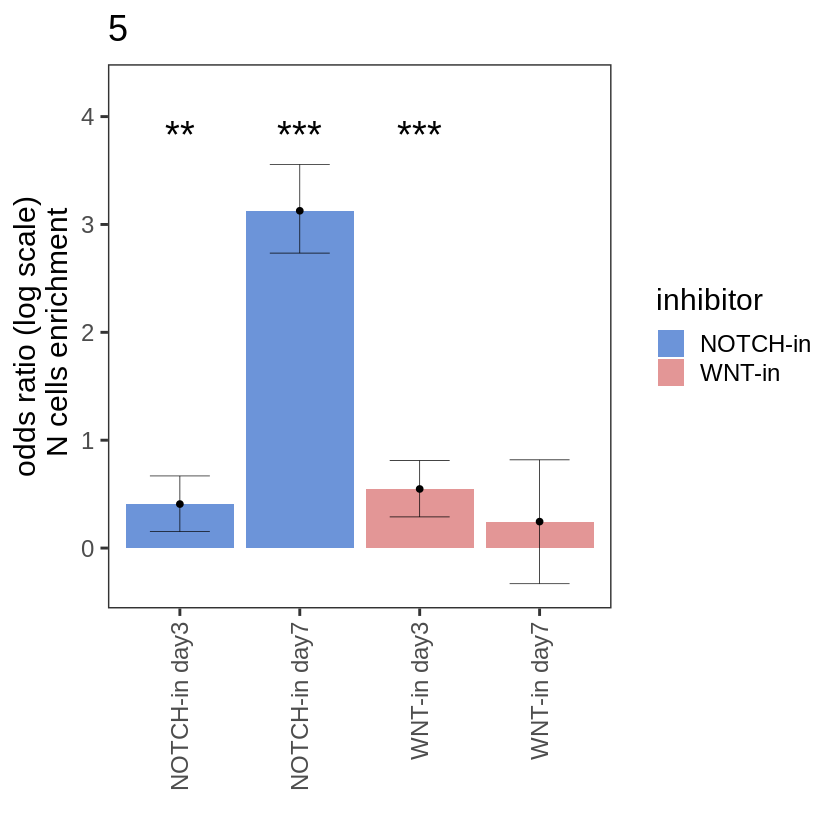

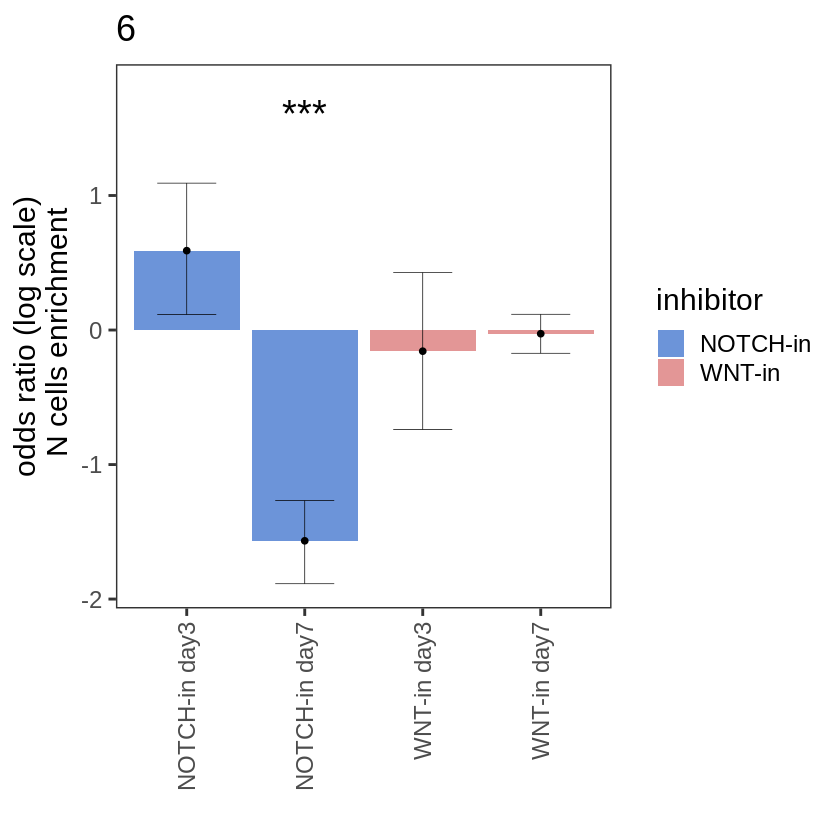

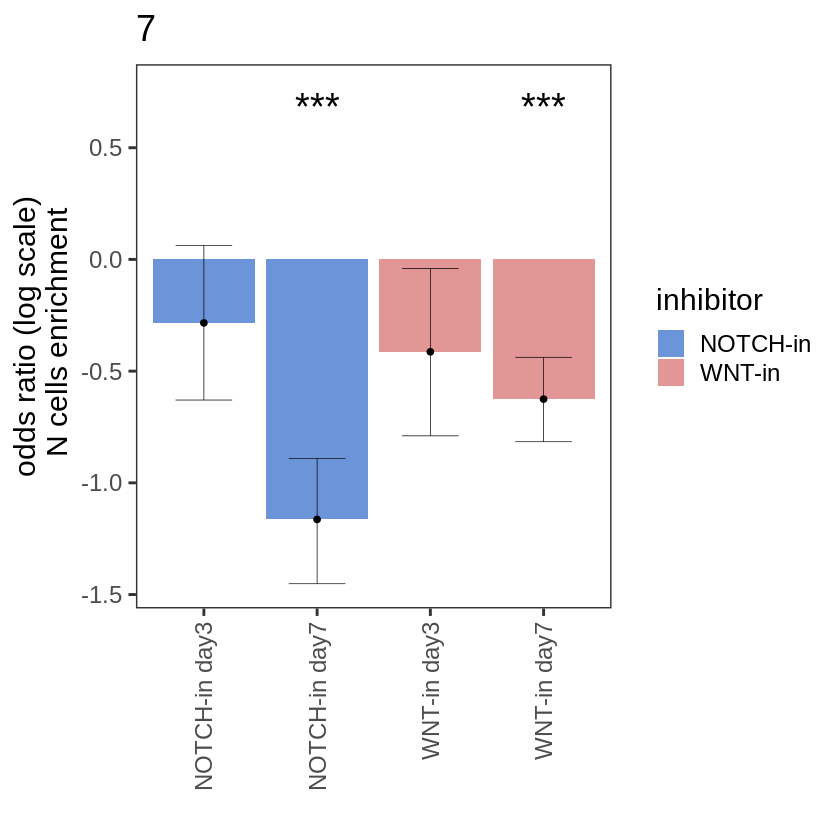

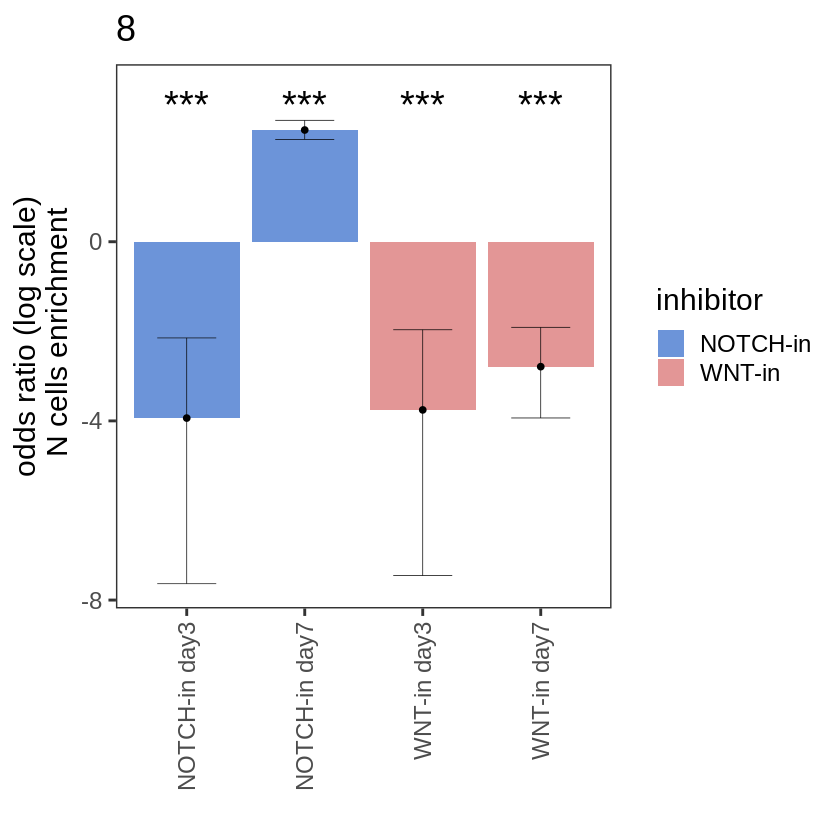

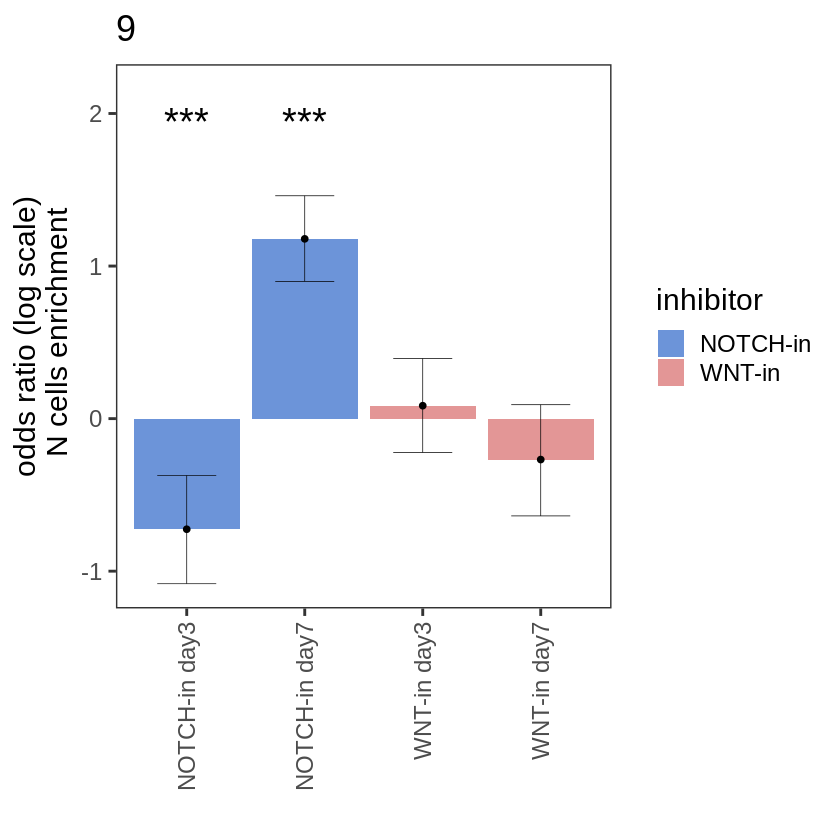

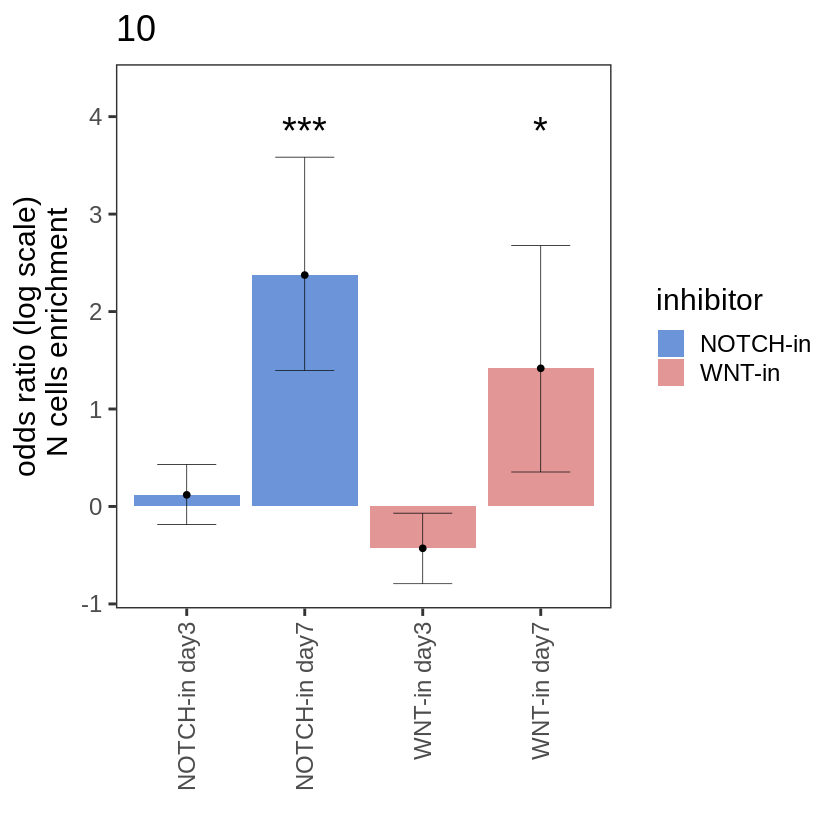

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]


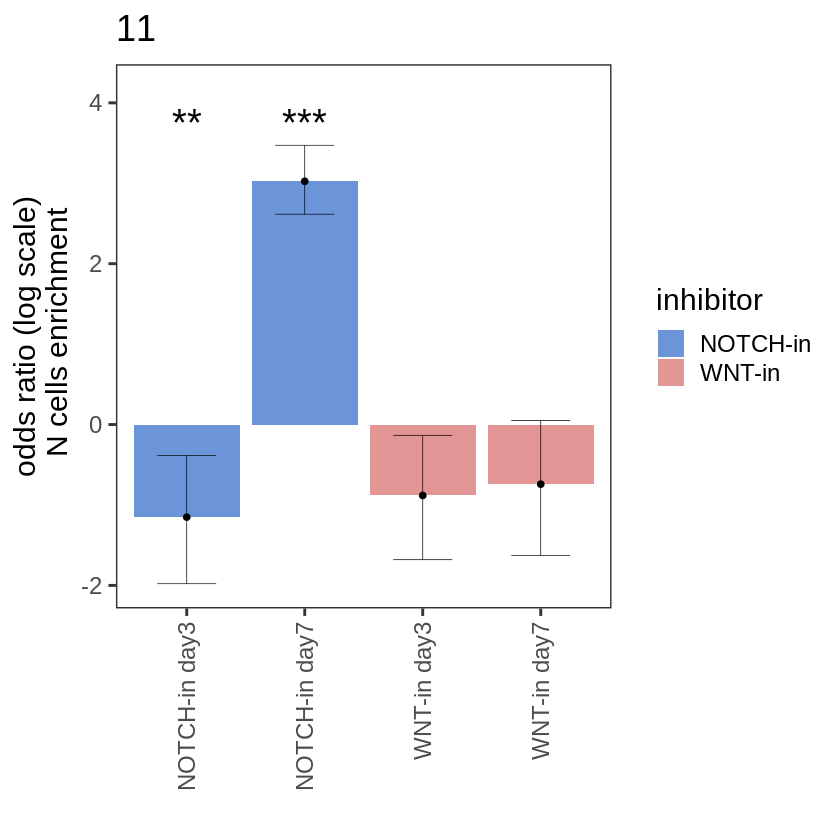

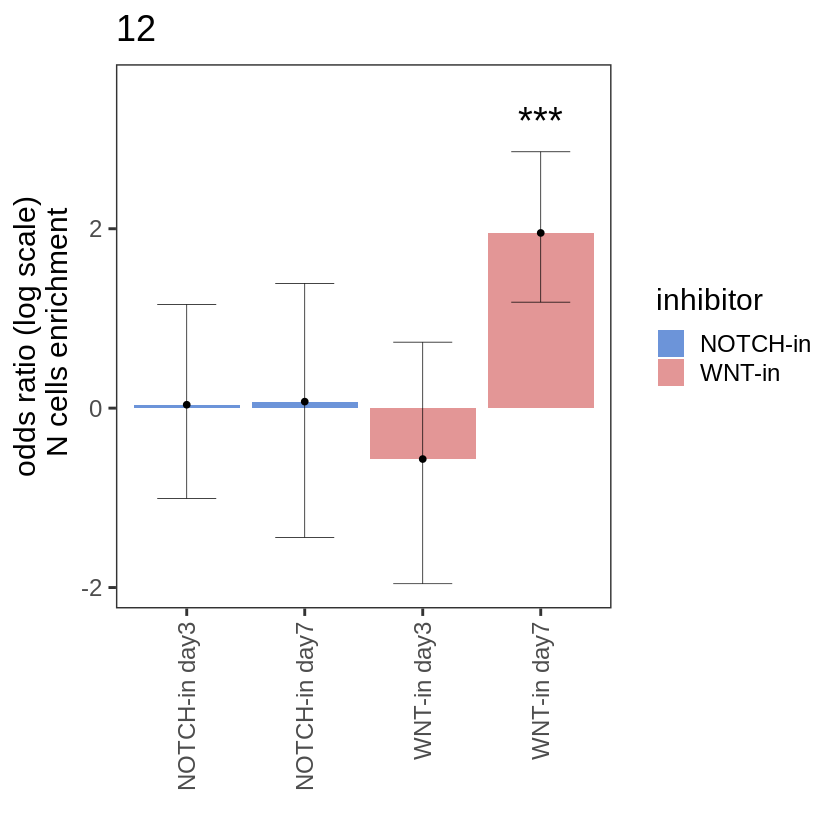

In [9]:
inhibitors = setdiff(metadata$Inhibition, 'N_I')
times = c(3, 7)
Re = list()
for (cl in unique(metadata$clusters) )
    try(Re[[cl]] <- test_cluster(cl))
Re